<a href="https://colab.research.google.com/github/naraB/handson-ml-notes/blob/master/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification

In [0]:
import numpy as np

## Downloading the dataset

In [72]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

Datasets loaded by Scikit-Learn generally have a similar dictionary structure: 

* *DESCR* key describing the dataset
* *data* key containing an array with one row per instance and one column per feature
* *target* key containing an array with labels

In [73]:
X,y = mnist['data'], mnist['target']
print('X shape', X.shape)
print('y shape', y.shape)

X shape (70000, 784)
y shape (70000,)


There are 70,000 images, and each image has 784 features. This is because each image is 28 * 28 pixels, and each feature simply represents one pixel's instensity, from 0 (white) to 255 (black). Lets take apeek at one digit from the dataset. All we need to do is grab an instance's feature vector, reshapre it to a 28 * 28 array, and display it using Matplotlib's imhsow() function:

(784,)


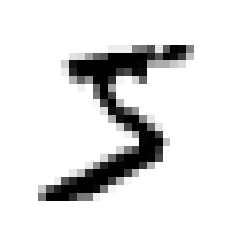

In [74]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
print(some_digit.shape)
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [75]:
y[0]

'5'

Note that the label is a string. Most ML algorithms expect numbers, so lets cast y to integer:

In [0]:
y = y.astype(np.uint8)

## Creating test and train set

The MNIST dataset is already split into a training set (the first 60,000 images) and test set (the last 10,000 images)

In [0]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

The training data is already shuffled for us

## Binary Classification

Let's simplify the problem for now and only tr to identify one digit - for example, te number 5. This "5-detector" will be an example of a binary classifier, capable of distinguishing between just two classes, 5 and not-5

In [0]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

### Training

Let's use a *Stochastic Gradient Descent* (SGD) classifier, Scikit-learn's SGDClassifier class.

The classifier has the advantage of being capable of handling very large datasets efficiently. This is in part because SGD deals with training instances independently, one at a time (which also makes SGD well suited for online learning), as we will see later

In [79]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Now we can use it to detect images of the number 5:

In [80]:
sgd_clf.predict([some_digit])

array([ True])

### Performance Measures

Evaluating a classifier is often significantly trickier than evaluating a regressor, so we will spend a large part of this chapter on this topic. There are many performance measures available.

#### Measuring Accuracy Using Cross-Validation

A good way to evaluate a model is to use cross-validation

In [81]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others)

#### Confusion Matrix

A much better way to evaluate the performance of a classifier is to look at the confusion matrix. The general idea is to count the number of times instances of class A are classified as class B. For example, to know the number of times the classifier confused images of 5s with 3s, you would look in the fifth row and third column of the confusion matrix.

To compute the confusion matrix, we first need to have a set of predictions so that they can be compared to the actual targets.

In [0]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [83]:
y_train_pred

array([ True, False, False, ...,  True, False, False])

Just like the cross_val_score() function, cross_val_predict() performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold. This means that you get a clean prediction for each instance in the training set ("clean" meaning that the prediction is made by a model that never saw the data during training)

cross_val_predict() splits the data into K parts (as does cross_val_score()) and then for i=1...k iterations: 

* takes the i-th part as test data and all other parts as training data

* trains the model with training data (all parts except i-th part)

* then by using this trained model, predicts labels for i-th part (test data)

In each iteration, label of i-th part of the data gets predicted. In the end cross_val_prediction concatenates all partially predicted labels and returns them as the final result.


In [84]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Each row in a confusion matrix represents an actual class, while each column represents a predicted class. The first row of this matrix considers non-5 images (*negative class*): 53,892 of them were correctly classified as non-5s (they are called *true negatives*), while the remaining 687 were wrongly classified as 5s (*false positives*). The second row considers the images of 5s (*positive class*): 1,891 were wrongly classified as non-5s (*false negatives*), while the ramaining 3,530 were correctly classified as 5s (*true positives*). 

To recap:

* *negative class*: first row (non-5 images)
* *postive class*: second row (images of 5s)
* *true negatives*: correctly classified as non 5's (52,892)
* *true postives*: correctly classified as 5's (3,530)
* *false postives*: wrongly classified as 5's (687)
* *false negatives*: wrongly classified as non 5's (1,891)




A perfect classifier would have only true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal

In [85]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

#### Precision and Recall

**Precision = the accuracy of the positive predictions; the precision of the classifier**

* precision = TP / (TP + FP)

* TP = number of true positives
* FP = number of false positives

* What is the ratio of correctly classified 5's and wrongly classified 5's (false positives) + correctly classified 5's

* What percentage are the actual correctly predicted 5's out of all predicted 5's

* How precise was my positive predictions

***Recall* (also *sensitivity* or the *true positive rate*) = the ratio of positives instances that are correctly detected by the classifier**

* recall = TP / (TP + FN)

* FN = false negatives

* What is the ratio of correctly classified 5's and missed 5's (wrongly classified non-5's) + correctly classified 5's

* Ratio of how many out of all of the positive class we classified correctly

* How many actual positives did I miss?

In [86]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [87]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

Precision
* Wrongly classified approx. 17% non 5's as 5's
* When it claims an image represents a 5, it's correct 83% of the time


Recall
* Wrongly classified approx 35% as non 5's even though they were 5's
* Detects 65% of all of the 5's


##### F1 Score

F1 score = combines precision and recall into a single metric and is a simple way to compare two classifiers

The F1 score is the harmonic mean of precision and recall. Whereas the regular mean trats all values equally, the harmonic mean gives much more weight to low values. As aresult, the classifier will only get a high F1 score if both recall and precision are high.

F1 = 2 * (precision * recall) / (precision + recall)

In [88]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

The F1 score favors classifiers that have similiar precision and recall. This is not always what you want: in some contexts you mostly care about precision, and in other contexts you really care about recall. For example, if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision). On the other hand, suppose you train a classifier to detect shoplifters in surveillance images: it is probably fine if your classifier has only 30% precision as long as it has 99% recall

Unfortunately, you can't have it both ways: increasing precision reduces recall, and vice versa. This is called the *precision/recall trade-off*

##### Precision/Recall Trade-off

To understand this trade-off, let's look at how the SGDClassifier makes its classification decisions. For each instance, it computes a score based on a decision function. If that score is greater than a threshold, it assigns the instance to the positive class; otherwise it assigns it to the negative class. Conversly, lowering the threshold increases recall and reduces precision

Scikit-Learn does not let you set the threshold directly, but it does give you access to the decision scores that it uses to make predictions. Instead of calling the classifier's predict() method, you can call its decision_function() method, which returns a score for each instance, and then use any threshold you want to make predictions base on those scores:


In [89]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [90]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

How do you decide which threshold to use? 
* First, use the cross_val_predict() function to get the scores of all instances in the training set, but this time specify that you want to return decision scores instead of predictions:

In [0]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

With these scores, use the precision_recall_curve() function to compute precision and recall for all possible thresholds:

In [0]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Finally, use Matplotlib to plot precision and recall as functions of the threshold value:

In [0]:
# highlight the threshold and add the legend, axis label, and grid
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
  plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')

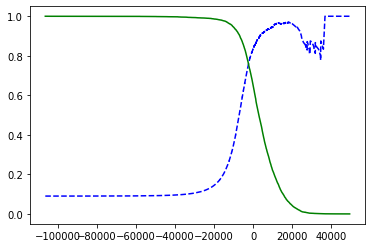

In [94]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Another way to select a good precision/recall trade-off is to plot precision directly against recall:

In [95]:
thresholds_90_precision = thresholds[np.argmax(precisions >= 0.90)]
thresholds_90_precision

3370.0194991439557

In [0]:
y_train_pred_90 = (y_scores >= thresholds_90_precision)

In [97]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [98]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706